In [94]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.utils import to_categorical

# Param

In [ ]:
data_dir = 'dataset/edge_detection'
classes = ['1000', '2000', '5000', '10000', '20000', '50000', '100000']
IMG_SIZE = (256,256)

EPOCHS = 60
BATCH_SIZE = 16

# Preprocessing

In [156]:
raw_dir = 'dataset/raw'

# Create output directory structure
Path(data_dir).mkdir(parents=True, exist_ok=True)
for cls in classes:
    Path(os.path.join(data_dir, cls)).mkdir(parents=True, exist_ok=True)

def apply_edge_detection(image):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    blurred = cv2.GaussianBlur(gray, (13, 13), 0)

    sobel_x = cv2.Sobel(blurred, cv2.CV_64F, dx=1, dy=0, ksize=3)  # x
    sobel_y = cv2.Sobel(blurred, cv2.CV_64F, dx=0, dy=1, ksize=3)  # y
    
    # Combine the two gradients
    edge = cv2.magnitude(sobel_x, sobel_y)
    return edge

# Loop through each class
for cls in classes:
    raw_class_dir = os.path.join(raw_dir, cls)
    output_class_dir = os.path.join(data_dir, cls)
    
    # Process each image in the class folder
    for img_name in tqdm(os.listdir(raw_class_dir), desc=f'Processing {cls}'):
        img_path = os.path.join(raw_class_dir, img_name)
        
        # Read the image
        image = cv2.imread(img_path)

        # Apply edge detection
        edges = apply_edge_detection(image)

        # Save the processed image to the edge_detection directory
        output_img_path = os.path.join(output_class_dir, img_name)
        cv2.imwrite(output_img_path, edges)

print("Edge detection preprocessing completed.")

Processing 100000: 100%|██████████| 80/80 [00:03<00:00, 23.47it/s]

Edge detection preprocessing completed.


# Feature Extraction (SIFT ORB)

In [184]:
def pad_descriptors(descriptors, max_length=128):
    if descriptors is None:
        return np.zeros((max_length, 128))  # Assuming descriptors have a 128-dimensional vector size
    if descriptors.shape[0] < max_length:
        padded = np.zeros((max_length, descriptors.shape[1]))
        padded[:descriptors.shape[0], :] = descriptors
        return padded
    else:
        return descriptors[:max_length, :]

def extract_features(img_path):
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, IMG_SIZE)
    
    sift = cv2.SIFT_create()
    orb = cv2.ORB_create()

    sift_keypoints, sift_descriptors = sift.detectAndCompute(image, None)
    orb_keypoints, orb_descriptors = orb.detectAndCompute(image, None)

    return sift_descriptors, orb_descriptors

# Build the vocabulary for BOVW using K-means clustering
def build_vocabulary(descriptors_list, k=500):
    # Stack all descriptors together for K-means
    all_descriptors = np.vstack(descriptors_list)
    
    # Perform K-means clustering to form the visual vocabulary using sklearn's KMeans
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(all_descriptors)
    
    return kmeans

# Function to compute histogram for BOVW representation
def compute_bovw_histogram(descriptors, kmeans):
    # Assign each descriptor to the nearest visual word (cluster center)
    words = kmeans.predict(descriptors)
    
    # Create a histogram of visual words
    histogram = np.zeros(kmeans.cluster_centers_.shape[0])
    for word in words:
        histogram[word] += 1
    
    return histogram

# Function to load dataset and compute BOVW for each image
def load_dataset(kmeans=None):
    x = []
    y = []
    
    descriptors_list = []  # List to store all descriptors for vocabulary building
    
    for label, cls in enumerate(classes):
        cls_dir = os.path.join(data_dir, cls)
        for img_name in os.listdir(cls_dir):
            img_path = os.path.join(cls_dir, img_name)
            sift_descriptors, orb_descriptors = extract_features(img_path)
            
            if sift_descriptors is not None:
                descriptors_list.append(sift_descriptors)
                # We can also consider using orb_descriptors if needed
                # descriptors_list.append(orb_descriptors)
    
    # If no vocabulary exists, create one using K-means
    if kmeans is None:
        kmeans = build_vocabulary(descriptors_list)
    
    # Now extract BOVW histograms for each image
    for label, cls in enumerate(classes):
        cls_dir = os.path.join(data_dir, cls)
        for img_name in os.listdir(cls_dir):
            img_path = os.path.join(cls_dir, img_name)
            sift_descriptors, orb_descriptors = extract_features(img_path)
            
            if sift_descriptors is not None:
                # Convert the descriptors to BOVW histogram
                histogram = compute_bovw_histogram(sift_descriptors, kmeans)
                x.append(histogram)
                y.append(label)
    
    # Convert to numpy arrays
    x = np.array(x)
    y = np.array(y)

    # Normalize feature vectors (Optional)
    x = x / np.linalg.norm(x, axis=1, keepdims=True)

    return x, y, kmeans

In [185]:
x, y, kmeans = load_dataset()
print(x.shape)

(560, 500)


In [186]:
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.2, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_temp,y_temp, test_size=0.5, random_state=42)

y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)
y_val = to_categorical(y_val, num_classes=7)


In [187]:
model = Sequential([
    Dense(256, activation='relu', input_dim=x_train.shape[1]),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(classes), activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


c:\Users\kodya\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_54 (Dense)                │ (None, 256)            │       128,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 162,055 (633.03 KB)

 Trainable params: 162,055 (633.03 KB)

 Non-trainable params: 0 (0.00 B)

In [188]:
history = model.fit(
    x_train, 
    y_train, 
    validation_data=(x_test, y_test), 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE)

Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.1101 - loss: 1.9472 - val_accuracy: 0.1429 - val_loss: 1.9300
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3096 - loss: 1.8965 - val_accuracy: 0.1964 - val_loss: 1.8919
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4841 - loss: 1.7923 - val_accuracy: 0.3750 - val_loss: 1.7850
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5817 - loss: 1.5977 - val_accuracy: 0.6250 - val_loss: 1.5557
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7182 - loss: 1.2879 - val_accuracy: 0.7143 - val_loss: 1.2440
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8246 - loss: 0.9414 - val_accuracy: 0.8214 - val_loss: 0.9589
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8764 - loss: 0.6329 - val_accuracy: 0.8214 - val_loss: 0.7569
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9190 - loss: 0.4455 - val_accuracy: 0.8571 - v

In [189]:
# fungsi buat evaluate model
def modelEvaluation(history, m):    
    plt.figure(figsize=(14, 4))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

In [190]:
x_test.shape

(56, 500)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8304 - loss: 1.1606 
Validation Loss: 1.137886643409729
Validation Accuracy: 0.8392857313156128


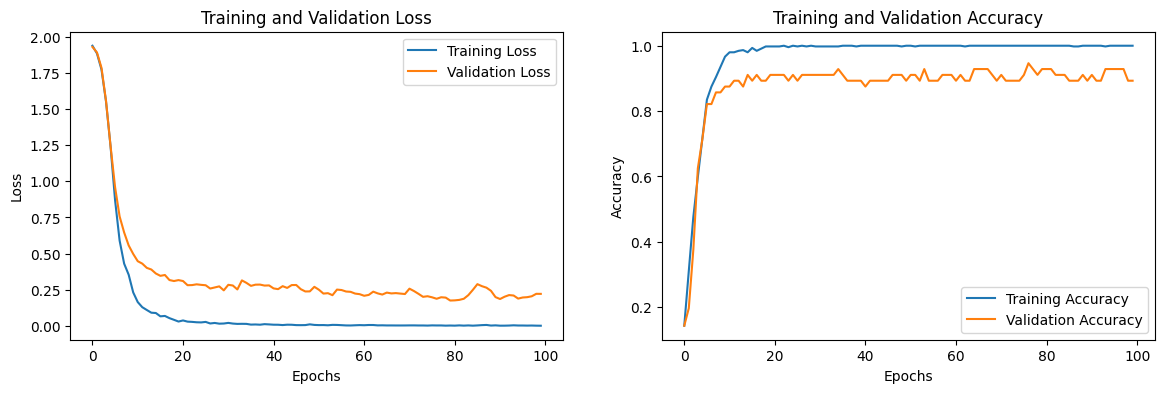

In [191]:
val_loss, val_accuracy = model.evaluate(x_val, y_val)

print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')

modelEvaluation(history, model)